In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit

In [3]:
import vice

from surp import subgiants
from surp import gce_math as gcem
from surp.gce_math import MH_to_Z, Z_to_MH, Z_SUN
import surp

import arya

In [4]:
arya.style.set_size((4, 2*np.sqrt(2)))

In [5]:
surp.yields.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 6.20e-02 (Z-Z0),    1.50 × cristallo11             0                              
                    Z>=-1.00e+00; 8.67e-04 +                                                                     
                    0.00e+00 Z, else                                                                             

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
agb_model

In [6]:
df = subgiants
filt = ~df["high_alpha"]
subgiants = df[filt].copy() #low alpha is closer to equilibrium

subgiants["C_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["MG_FE_ERR"]
subgiants["N_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["N_FE_ERR"]

df_subgiants = subgiants[["C_MG", "MG_H", "C_MG_ERR"]]

all_abundances = pd.read_csv("../notebooks/data_analysis/all_data.csv")
stars = pd.read_csv("../data/amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63], engine="python")
stars["C_MG"] =  stars["[C/H]3N"] - stars["[O/H]3N"]
stars["MG_H"] =  stars["[O/H]3N"]
stars["C_MG_ERR"] = stars["e_[C/H]3N"] + stars["e_[O/H]3N"]

df_stars = stars[["C_MG", "MG_H", "C_MG_ERR"]]

all_abundances["C_MG"] = all_abundances["[c/o]"]
all_abundances["MG_H"] = all_abundances["[o/h]"]
all_abundances["C_MG_ERR"] = all_abundances["[c/o]_err"]

stars_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "star")]
RL_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "RL")]
DLA_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "DLA")]
dwarf_all = all_abundances[["C_MG", "MG_H", "C_MG_ERR"]][(~np.isnan(all_abundances.C_MG)) & (all_abundances.type == "dwarf")]

(-0.3, 0.1)

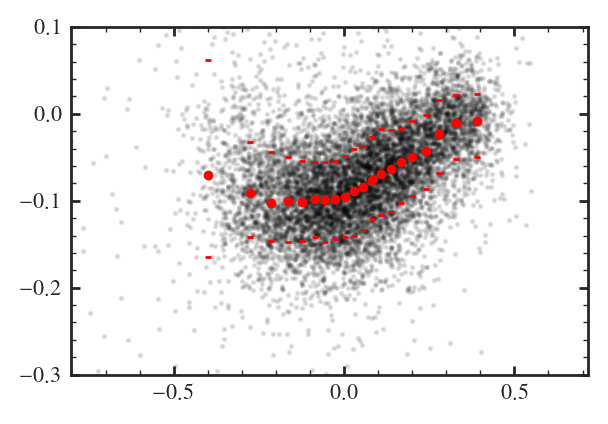

In [7]:
arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="median", color="r", errorbar="pi")
#arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="mean", color="r", errorbar=None)

plt.scatter(subgiants.MG_H, subgiants.C_MG, s=1, color="k", alpha=0.1, zorder=-1)
plt.xlim(-0.8)
plt.ylim(-0.3, 0.1)

Text(0, 0.5, '[c/o]')

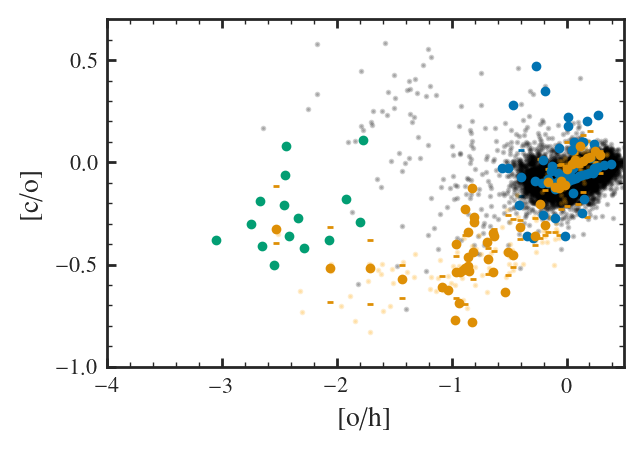

In [8]:
df_s = arya.medianplot(subgiants, x="MG_H", y="C_MG", numbins=20, stat="median", errorbar="pi", zorder=3)
plt.scatter(subgiants.MG_H, subgiants["C_MG"], s=1, color="k", alpha=0.2)

df_a = arya.medianplot(all_abundances, x="MG_H", y="C_MG", binsize=10, stat="median", errorbar="pi", zorder=3)
plt.scatter(df_stars.MG_H, df_stars["C_MG"], s=1, color="orange", alpha=0.2)

MoverH = df_s.data.x
c_o = df_s.data.y
c_o_err = (df_s.data.y_h - df_s.data.y_l)/(df_s.data.counts)**0.5

MoverH_a = df_a.data.x
c_o_a = df_a.data.y
c_o_err_a = (df_a.data.y_h - df_a.data.y_l)/(df_a.data.counts)**0.5
plt.scatter(RL_all.MG_H, RL_all.C_MG)
plt.scatter(dwarf_all.MG_H, dwarf_all.C_MG)
plt.scatter(DLA_all.MG_H, DLA_all.C_MG)




plt.xlim(-4, 0.5)
plt.ylim(-1, 0.7)
plt.xlabel("[o/h]")
plt.ylabel("[c/o]")

In [9]:
def y_mod(x, a, b):
    return a*(x-Z_SUN) + b

In [10]:
def co_to_yc(c_o):
    return y_mg_cc * gcem.brak_to_abund(c_o, "C", "Mg")

y_mg_cc = vice.yields.ccsne.settings["mg"]
y_o_cc = vice.yields.ccsne.settings["o"]
y_c_cc = vice.yields.ccsne.settings["c"]


[0.02368623 0.00271175]
[1.5590518e-03 1.4688615e-05]


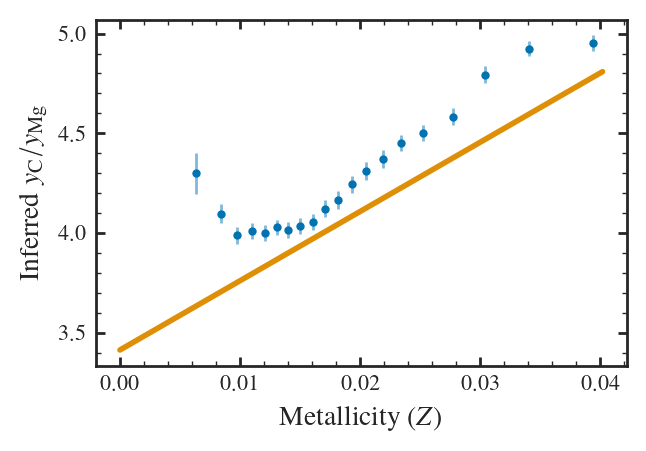

In [11]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
# parameters

y_c = co_to_yc(c_o)
y_c_err = np.float64(y_c * np.log(10) * c_o_err)

Z = MH_to_Z(MoverH)
a,b,c = plt.errorbar(Z, y_c/y_mg_cc, y_c_err/y_mg_cc, fmt="o", capsize=0, ms=2)
c[0].set_alpha(0.5)

popt, covt = curve_fit(y_mod, Z, y_c, sigma=y_c_err, p0=(0.005, 0.1))


# plt.plot(fe_h, y_agb(fe_h))
x_mod = np.linspace(-3, 0.5)
print(popt)
print(np.diag(covt)**0.5)

# plt.plot(MoverH, y_mod(MoverH, *popt))
x = np.linspace(-3, 0.4, 100)
Z = MH_to_Z(x)
plt.plot(Z, 10**-0.02*y_mod(Z, 0.0237, 0.00271)/y_mg_cc, lw=2, label="model")


plt.xlabel(r"Metallicity ($Z$)")
#leg = plt.legend()
#leg.legendHandles[0].set_visible(False)
plt.ylabel(r"Inferred $y_{\rm C}/y_{\rm Mg}$")
plt.tight_layout()
plt.savefig("figures/analytic.pdf")



In [12]:
def y_mod2(x, a, b, c):
    return a + b*(x - Z_SUN)+ c*(x-Z_SUN)**2

[0.00270344 0.01997399 0.25989582]
[1.51061778e-05 2.81367824e-03 1.66638324e-01]


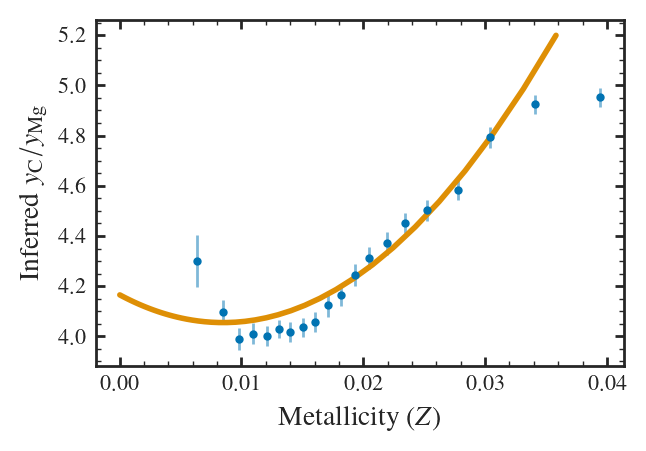

In [13]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
# parameters

y_c = co_to_yc(c_o)
y_c_err = np.float64(y_c * np.log(10) * c_o_err)

Z = MH_to_Z(MoverH)
a,b,c = plt.errorbar(Z, y_c/y_mg_cc, y_c_err/y_mg_cc, fmt="o", capsize=0, ms=2)
c[0].set_alpha(0.5)

chop = 3
popt, covt = curve_fit(y_mod2, Z, y_c, sigma=y_c_err, p0=(0.003, 0.1, 1))


# plt.plot(fe_h, y_agb(fe_h))
x_mod = np.linspace(-3, 0.5)
print(popt)
print(np.diag(covt)**0.5)

# plt.plot(MoverH, y_mod(MoverH, *popt))
x = np.linspace(-3, 0.35, 100)
Z = MH_to_Z(x)
#plt.plot(Z, 10**-0.04*y_mod2(Z, 2.77e-3, 0.025, 1.15)/y_mg_cc, lw=2, label="model")
plt.plot(Z, y_mod2(Z, 0.0027, 0.015, 1)/y_mg_cc, lw=2, label="model")

#plt.plot(Z, surp.yields.y_c_total(Z)/y_mg_cc*10**-0.02, lw=2)

plt.xlabel(r"Metallicity ($Z$)")
#leg = plt.legend()
#leg.legendHandles[0].set_visible(False)
plt.ylabel(r"Inferred $y_{\rm C}/y_{\rm Mg}$")
plt.tight_layout()
plt.savefig("figures/analytic.pdf")

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.28e-03 + 6.20e-02 (Z-Z0),    1.50 × cristallo11             0                              
                    Z>=-1.00e+00; 8.67e-04 +                                                                     
                    0.00e+00 Z, else                                                                             

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



total c yield
agb_model

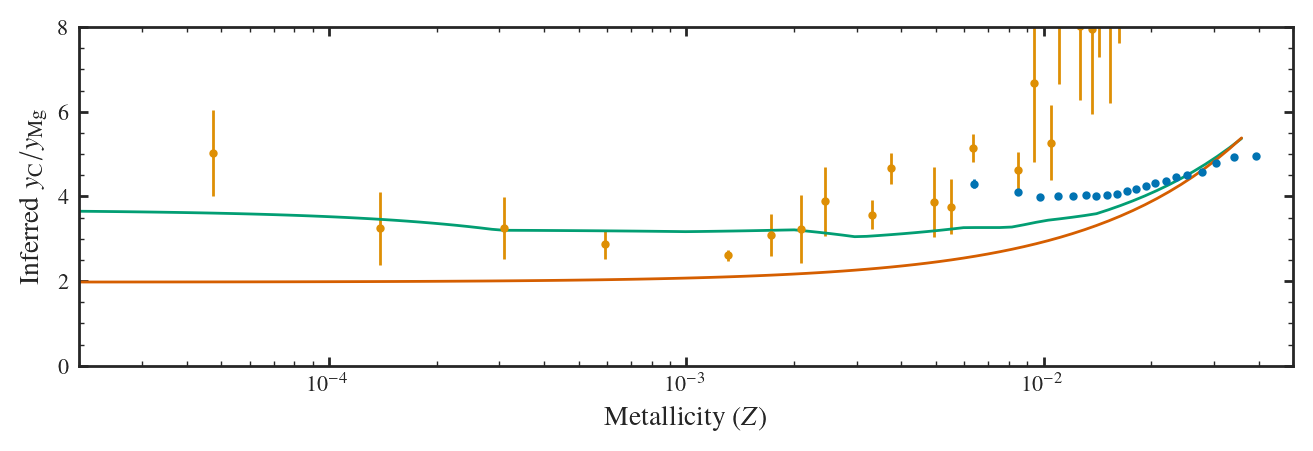

In [23]:
plt.figure(figsize=(20/3, 10/3/np.sqrt(2)))
# parameters
Z = MH_to_Z(MoverH)


y_c = co_to_yc(c_o)
y_c_err = y_c * np.log(10) * c_o_err

Z = MH_to_Z(MoverH)
a,b,c = plt.errorbar(Z, y_c/y_mg_cc, y_c_err/y_mg_cc, fmt="o", capsize=0, ms=2)

x = np.linspace(-3, 0.35, 100)
Z = MH_to_Z(x)


y_c_a = y_o_cc*gcem.brak_to_abund(c_o_a, "C", "O")
y_err_a = y_c_a * np.log(10) * c_o_err_a

a,b,c = plt.errorbar(MH_to_Z(MoverH_a), y_c_a/y_mg_cc, y_err_a/y_mg_cc, fmt="o", capsize=0, ms=2)


mass_yields = []
for z in Z:
    vice.yields.ccsne.settings["c"] = 0
    vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c")
    m_c, times = vice.single_stellar_population("c", Z=z)
    mass_yields.append(m_c[-1]/1e6/y_mg_cc)

def y_mod3(Z):
    return 0.5*(gcem.Z_to_MH(Z) + 1.5)**2 + 26*(Z-gcem.Z_SUN)+ 1.75

surp.yields.set_yields(f_agb=0.2)

y_mod3 = lambda Z: vice.yields.ccsne.settings["c"](Z) /y_mg_cc
mass_yields = np.array(mass_yields)
y_tot = y_mod3(Z) + mass_yields

plt.plot(Z, y_tot*10**-0.02, label="total")
# plt.plot(Z,  mass_yields, lw=2, label="model")

plt.plot(Z, y_mod3(Z))


plt.xlabel(r"Metallicity ($Z$)")
plt.xlim(2e-5, 0.05)
plt.ylim(0, 8)
plt.ylabel(r"Inferred $y_{\rm C}/y_{\rm Mg}$")
plt.xscale("log")
#plt.xscale("asinh", linear_width=0.001)
#plt.gca().xaxis.set_minor_locator(mpl.ticker.AsinhLocator(0.0001, subs=(2,4,6,8)))
#plt.xticks([0, 1e-4,1e-3, 1e-2])


plt.tight_layout()

# Nitrogen

In [20]:
β = 7e-4
def y_agb_n(monh):
    return β*10**monh


y_cc_n0 = 9e-4

In [21]:
def mod_n(x, a, b):
    return a + b*10**x

In [22]:
# parameters
y_o_cc = 0.015

y_n = y_o_cc*gcem.brak_to_abund(n_o, "N", "O")
y_n_err = y_n * np.log(10) * n_o_err

y_n_cc = y_n 
a,b,c = plt.errorbar(MoverH, y_n_cc, y_n_err, fmt="o", capsize=0, ms=2)

c[0].set_alpha(0.5)

# plt.scatter(all_dat["[o/h]"], all_dat.y_c, s=1)

popt, covt = curve_fit(mod_n, MoverH, y_n_cc)
 
plt.plot(MoverH, y_agb_n(MoverH)+y_cc_n0, lw=2)

# plt.plot(MoverH, mod_n(MoverH, *popt), zorder=4, lw=2)
plt.xlabel("[Mg/H]")
plt.ylabel(r"$y_{\rm N}^{\rm CC}$")
sp.save("analytic_n.pdf")

NameError: name 'n_o' is not defined

In [ ]:
arya.binnedplot(subgiants, x="MG_FE", y="C_MG")
arya.binnedplot(subgiants, x="O_FE", y="C_O", facecolor="orange")

In [ ]:
arya.binnedplot(subgiants, x="MG_H", y="C_MG")
arya.binnedplot(subgiants, x="O_H", y="C_O", facecolor="orange")